In [5]:
import numpy as np
import torch 
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms,utils
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5],std=[0.5])])

# 数据集载入
train_data = datasets.MNIST(root = "./data/",transform=transform,train = True,download = True)
test_data = datasets.MNIST(root="./data/",transform = transform,train = False)
print('训练集/测试集:',len(train_data),'/',len(test_data))

#加载器
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=32,shuffle=True,num_workers=2)
print('训练batch/测试batch:',len(train_loader),'/',len(test_loader))



训练集/测试集: 60000 / 10000
训练batch/测试batch: 1875 / 313


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

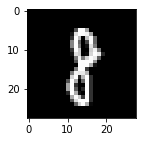

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(8)


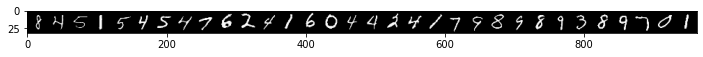

  8  4  5  1  5  4  5  4  7  6  2  4  1  6  0  4  4  2  4  1  7  9  8  9  8  9  3  8  9  7  0  1


In [28]:
data_iter = iter(train_loader)
nd = next(data_iter)
oneimg,label = nd[0][0],nd[1][0]
grid = utils.make_grid(oneimg)
grid = grid.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
grid = grid * std + mean
plt.figure(figsize=(2,2))
plt.imshow(grid)
plt.show()
print(label)

images, lables =nd
plt.figure(figsize=(12,4))
img = utils.make_grid(images,32)
# transpose 转置函数(x=0,y=1,z=2),新的x是原来的y轴大小，新的y是原来的z轴大小，新的z是原来的x大小
#相当于把x=1这个一道最后面去。
imgs = img.numpy().transpose(1,2,0) 
plt.imshow(imgs)
plt.show()
print(' ','  '.join('%d'%i for i in lables))


In [31]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.fh0 = nn.Linear(64*7*7,1024*3)#两个池化，所以是7*7而不是14*14
#         self.fh1 = nn.Linear(1024*3,1024)
        self.fh2 = nn.Linear(1024*3,256)
        
        self.fo = nn.Linear(256,10)
        self.dp = nn.Dropout(p=0.2)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7* 7)#将数据平整为一维的 
        x = self.dp(x)
        x = F.relu(self.fh0(x))
        x = self.dp(x)
#         x = F.relu(self.fh1(x))
        x = F.relu(self.fh2(x))  
        x = self.dp(x)
        x = self.fo(x)  
#         x = F.log_softmax(x,dim=1) NLLLoss()才需要，交叉熵不需要
        return x

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    fig, axes = plt.subplots(1, 2, figsize=[16, 5])
    sns.lineplot(iters, costs,color='red',label=label_cost, ax = axes[0]) 
    sns.lineplot(iters, accs,color='green',label=lable_acc,ax=axes[1]) 
    plt.show()
# train_iters = range(len(train_accs))

In [35]:
import datetime as dt
import tqdm.notebook as tqnb
tstart=dt.datetime.now()
train_accs = []
train_loss = []
torch.cuda.empty_cache()
net = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adagrad(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(net.parameters(),lr=0.001)#Adam优化方法比较时髦

roundx=1
pbar = tqnb.tqdm(total=len(train_loader)*roundx)
for epoch in range(roundx):
    running_loss = 0.0
    for i,data in enumerate(train_loader,0):#0是下标起始位置默认为0
        # data 的格式[[inputs, labels]]       
#         inputs,labels = data
        inputs,labels = data[0].to(device), data[1].to(device)
        #初始为0，清除上个batch的梯度信息
        optimizer.zero_grad()         

        #前向+后向+优化     
        outputs = net(inputs)
        print(outputs,labels) 
        break;
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # loss 的输出，每个一百个batch输出，平均的loss
        running_loss += loss.item()
#         if i%100 == 99:
#             print('%d,%d-%.3f' % (epoch+1,i+1,running_loss/100), end='|')
#             running_loss = 0.0
        train_loss.append(loss.item())

        # 训练曲线的绘制 一个batch中的准确率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)# labels 的长度
        correct = (predicted == labels).sum().item() # 预测正确的数目
        train_accs.append(100*correct/total)
        pbar.update(1)
pbar.close()
torch.cuda.empty_cache()
dt.datetime.now()-tstart

import seaborn as sns

draw_train_process('training',train_iters,train_loss,train_accs,'training loss','training acc')
print(train_accs[-20:])
print(dt.datetime.now()-tstart)


tensor([[-1.1394e-01, -2.4178e-02,  2.1690e-02, -6.6366e-02, -1.6661e-02,
          3.2471e-02, -1.4143e-01,  6.2551e-02, -9.7309e-02,  9.4218e-02],
        [-9.5700e-02,  1.2402e-02, -3.1001e-03, -7.8277e-02, -3.3622e-02,
          4.6528e-02, -9.5346e-02, -1.2432e-02, -1.4408e-02,  3.6849e-02],
        [-1.0861e-01, -2.2819e-03,  1.1558e-02, -9.0876e-02,  1.5543e-02,
         -1.9056e-02, -1.5030e-01,  1.1611e-02, -6.4352e-02,  4.0505e-02],
        [-9.1582e-02,  1.5645e-02,  1.4329e-02, -6.8616e-02, -8.7955e-03,
          5.7424e-02, -9.9330e-02,  9.8671e-03, -7.9833e-02,  4.7812e-02],
        [-1.6333e-01, -1.8010e-02, -1.8742e-02, -6.7778e-02, -2.9019e-02,
          9.6527e-03, -1.0557e-01, -6.0249e-04, -6.2101e-02,  3.8176e-02],
        [-1.1039e-01, -4.8708e-03, -4.4530e-02, -1.0386e-01, -4.4852e-02,
          3.3788e-02, -1.9203e-01,  2.4927e-02, -6.4472e-02,  9.4589e-02],
        [-9.1103e-02,  2.2631e-02, -2.5137e-02, -9.4565e-02,  1.6052e-02,
          2.1318e-02, -1.2149e-0

NameError: name 'train_iters' is not defined

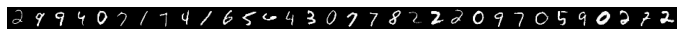

R -  -  -  -  -  -  -  -  -  -  -  -  6  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


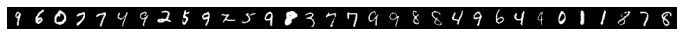

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -


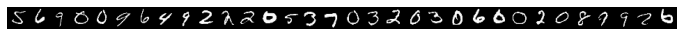

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  6  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  0  -  -  -  -  -  -  -  -


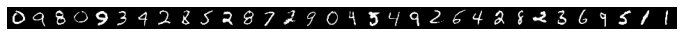

R -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


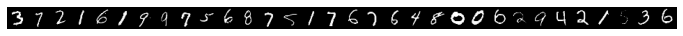

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -  -


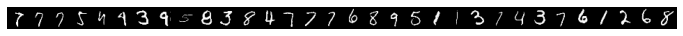

R -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


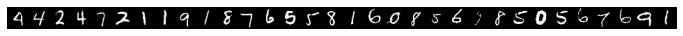

R 4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G 9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


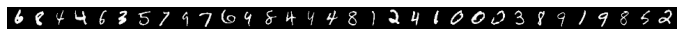

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  0  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -  -


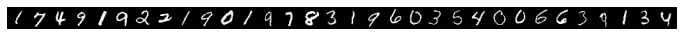

R 1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G 6  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


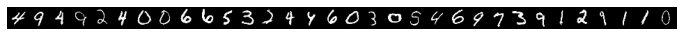

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


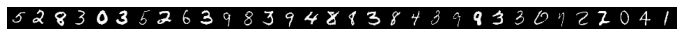

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -


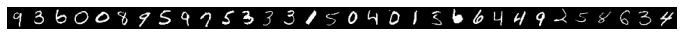

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  1  -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  3  -  -  -  -  -  -  -  -  -  -  -


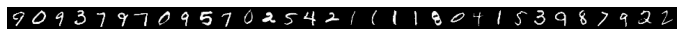

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -


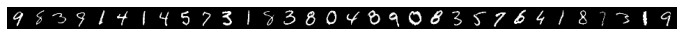

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  0  -  -  -  -  -  -  -  -  -  -  -  -  -  -


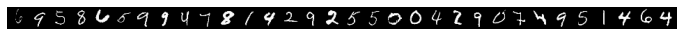

R -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  0  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -  -  -  -


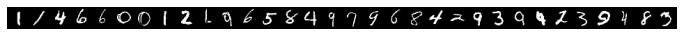

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -


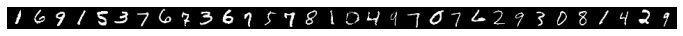

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  6  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -


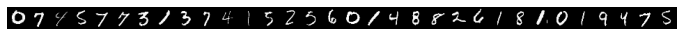

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  1  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -


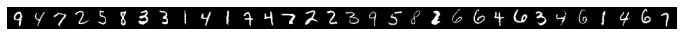

R -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


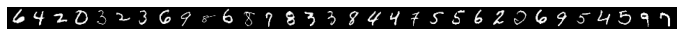

R -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


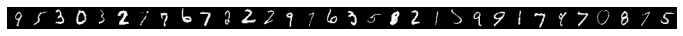

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -


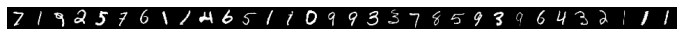

R -  -  -  -  -  -  -  -  -  -  -  -  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


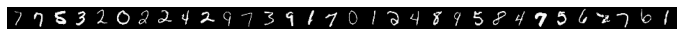

R -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -
G -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -


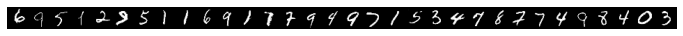

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


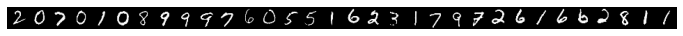

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -  -  -


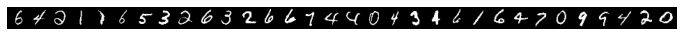

R -  -  -  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


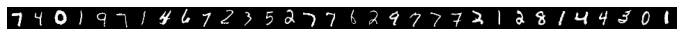

R -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -  -  -


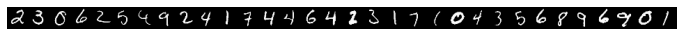

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  1  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -


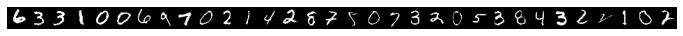

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  2  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  3  -  -  -  -  -  -  -  -  -  -  -


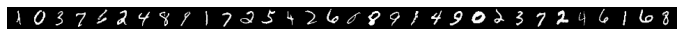

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  0  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


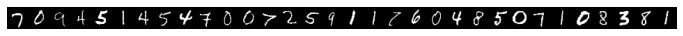

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -


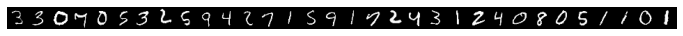

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -


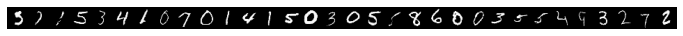

R 5  -  -  -  -  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G 3  -  -  -  -  -  6  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


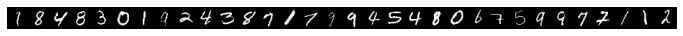

R 1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -
G 7  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -


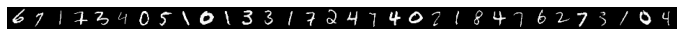

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -  -  -  -  -


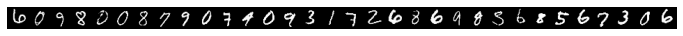

R -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  5  -  -  -  -  -  -  -  -


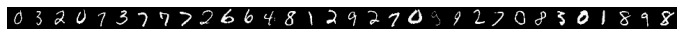

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  3  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  5  -  -  -  -  -  5  -  -  -  -  -


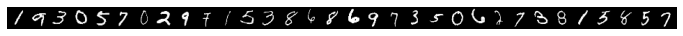

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  5  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -


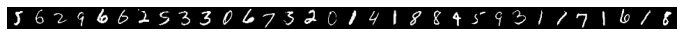

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  1  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -


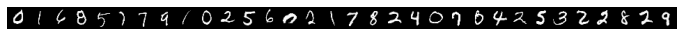

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -


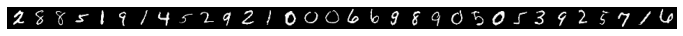

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -


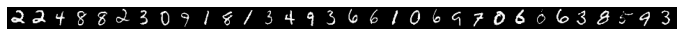

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  0  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  6  -  -  -  -  -  -


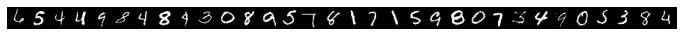

R -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


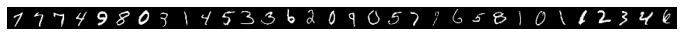

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -  1  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  6  -  -  -  -


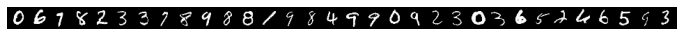

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  6  -  -  9  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  5  -


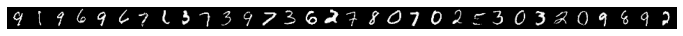

R -  -  -  -  -  -  -  6  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


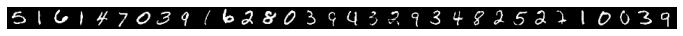

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  2  -  -  -  -  -  -  -  7  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  3  -  -  -  -  -  -  -  2  -  -  -  -  -


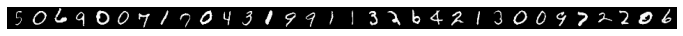

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -  -  -  -


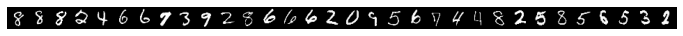

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8


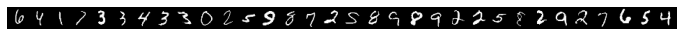

R -  -  -  7  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


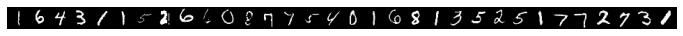

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  1
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8


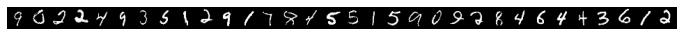

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -


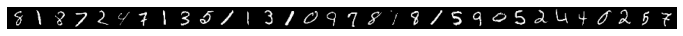

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -


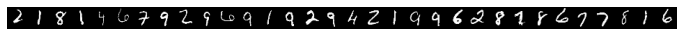

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -  -


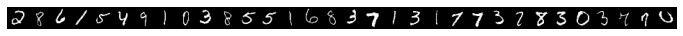

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -


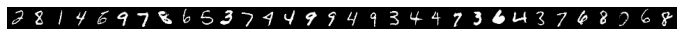

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  0  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -


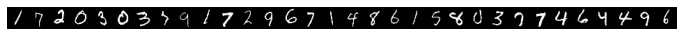

R -  -  -  -  -  -  -  7  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  5  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


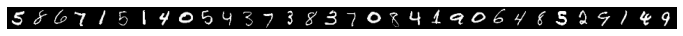

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -


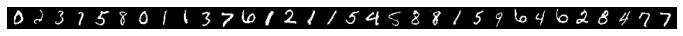

R -  -  -  -  -  -  -  -  -  -  -  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


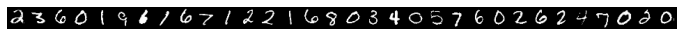

R -  -  -  -  -  -  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  7  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


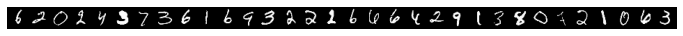

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  1  -  -  -  -  -


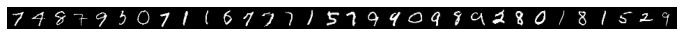

R -  -  -  -  -  3  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


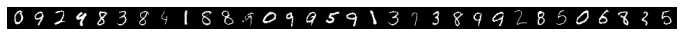

R -  -  -  4  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  9  -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


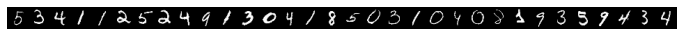

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -  -


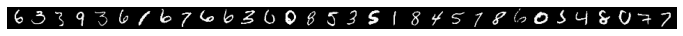

R -  -  -  -  -  -  -  -  -  -  -  -  0  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  6  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


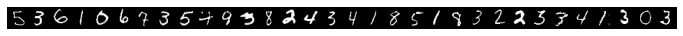

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -


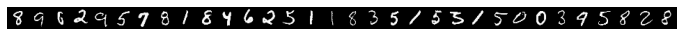

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -


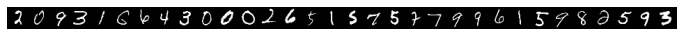

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -


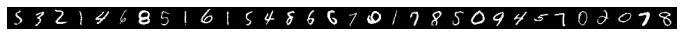

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  6  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


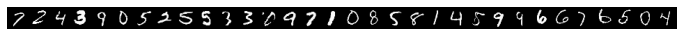

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -


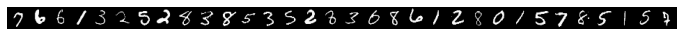

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9


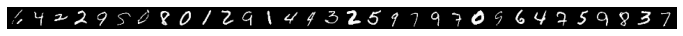

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


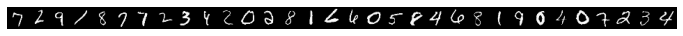

R -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


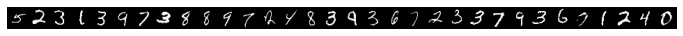

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -


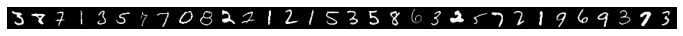

R -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


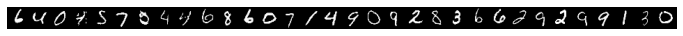

R -  -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  0  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


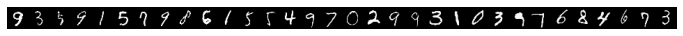

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -


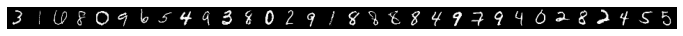

R -  -  6  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  0  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


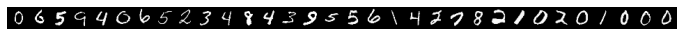

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  2  -  -  -  1  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  7  -  -  -  8  -  -  -  -  -  -  -


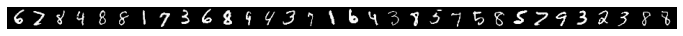

R -  7  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -
G -  2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -


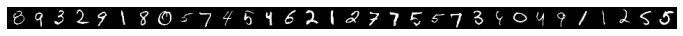

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -


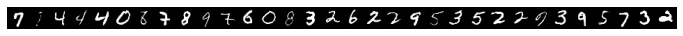

R -  -  -  -  -  -  -  -  -  -  -  6  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


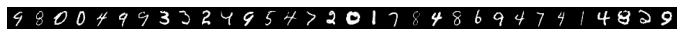

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -


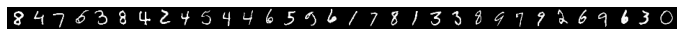

R -  -  -  5  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  6  -  -  -  -  -  -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


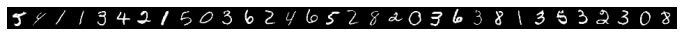

R -  4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


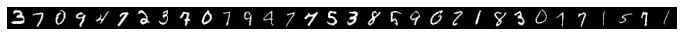

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  7  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  1  -  -  -  -  -


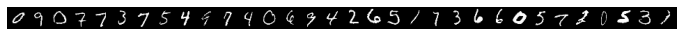

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  1
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  3


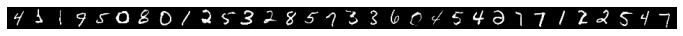

R -  1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


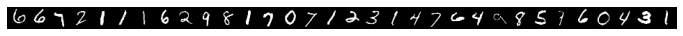

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -


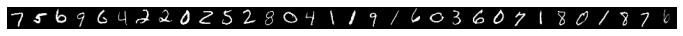

R -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


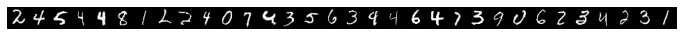

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -


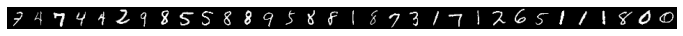

R 7  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G 9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


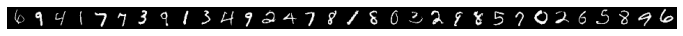

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -


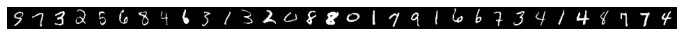

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -


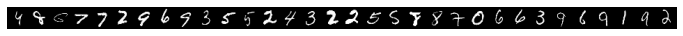

R -  -  6  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -  -  -  -  -  -  -


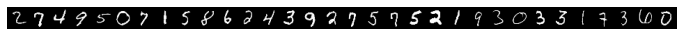

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -


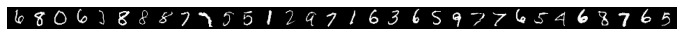

R -  -  -  -  3  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -
G -  -  -  -  2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -


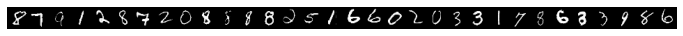

R -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


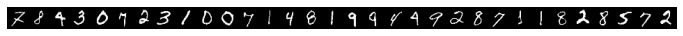

R 7  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G 3  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


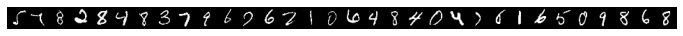

R -  -  -  -  -  -  -  -  -  -  -  7  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


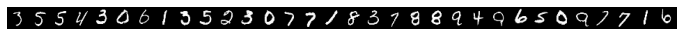

R -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


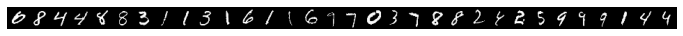

R 0  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -
G 8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -


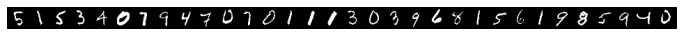

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -


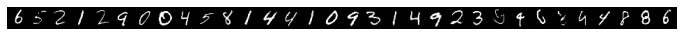

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -


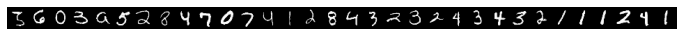

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  3  -  -  -  -  -  -  -  -  -  -  -  -  -


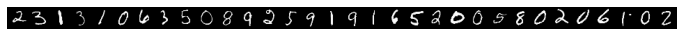

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  1  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  8  -  -


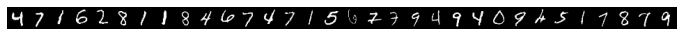

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  7  7  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  2  3  -  -  -  -  -  -  -  -  -  -  -  -  -


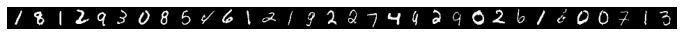

R -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  9  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  4  -  -  -  -  -  -  -  -  -  -  -  -


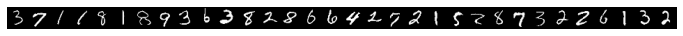

R -  -  -  1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
G -  -  -  8  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
算法评价:
              precision    recall  f1-score   support

           0    0.99591   0.99286   0.99438       980
           1    0.99642   0.98062   0.98845      1135
           2    0.98926   0.98159   0.98541      1032
           3    0.97763   0.99505   0.98626      1010
           4    0.99483   0.97963   0.98717       982
           5    0.98119   0.99439   0.98775       892
           6    0.99372   0.99061   0.99216       958
           7    0.99015   0.97763   0.98385      1028
           8    0.97368   0.98768   0.98063       974
           9    0.97268   0.98811   0.98033      1009

    accuracy                        0.98660     10000
   macro avg    0.98655   0.98682   0.98664     10000
weighted avg    0.98670   0.98660   0.98661     10000



In [133]:
dataiter = iter(test_loader)
images,labels = dataiter.next()




#device='cpu'
net.to(device)

from sklearn.metrics import classification_report

l=[]
p=[]
# pbar = tqnb.tqdm(total=len(test_loader))

for i,data in  enumerate(test_loader,0):
    inputs,labels = data[0].to(device), data[1]
    l.extend(labels)
    test_out = net(inputs)
    predicted = torch.max(test_out, dim=1)[1]
    p.extend(predicted.cpu())
    x=  predicted.cpu()-labels
    if len(x[x != 0]):
        plt.figure(figsize=(12,4))
        plt.xticks([])  #去掉x轴
        plt.yticks([])  #去掉y轴
        plt.axis('off')  #去掉坐标轴
        test_img = utils.make_grid(inputs.cpu(),32)
        test_img = test_img.numpy().transpose(1,2,0)
        test_img[test_img < 0] = 0
        plt.imshow(test_img)
        plt.show()
        ls=[]
        ps=[]
        for i in range(len(x)):
            if x[i] == 0 :
                ls.append('-')
                ps.append('-')
            else:
                ls.append('%d'%int(labels[i]))
                ps.append('%d'%int(predicted[i]))
                          
        print('R', '  '.join(j for j in ls))
        print('G', '  '.join(j for j in ps))

print('算法评价:')
print(classification_report(l, p,digits=5))



In [23]:
torch.save(net.state_dict(), "./ai_991")